## Summary

### Definition of model

The model was built with states being represented by a combination of the source and the agent's position. The agent's position is received as an observation to make the agent be space aware.

### Results

The model displays a good ability to find the source cell by spiralling around the space but once it finds it, the agent gets stuck in a loop of two actions.

This is due to the fact the a state is mapped to a single action. And once the agent is certain to be in the source state, it will need to play this action eventhough it could be approaching the source from any direction and therefore requiring some exploration inside this source cell.

The convergence rate is around 5% with 9 by 9 cells.

In [1]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent, QMDP_Agent, Infotaxis_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.simulation import run_test

from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from matplotlib import colors, patches
from tqdm.auto import tqdm


In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

In [3]:
indices = np.arange(101)
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal([50, 50], 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

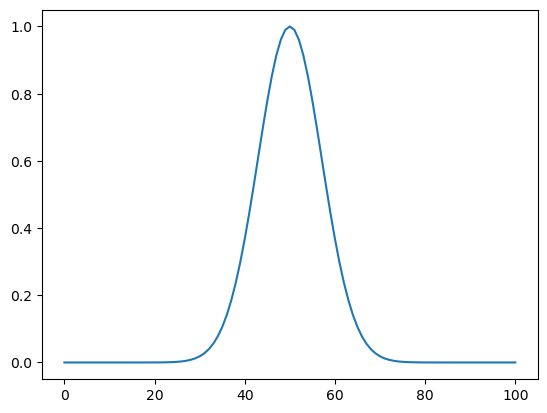

In [4]:
plt.plot(probability_map[50])

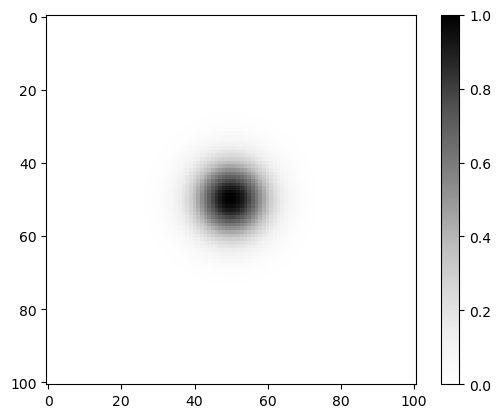

In [5]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

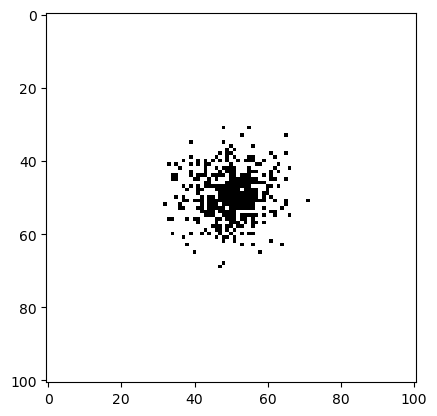

In [6]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cell and states

In [7]:
# Cell definition
# cells = [3,3]
cells = [9,9]
# cells = 9

if isinstance(cells, int):
    cells = np.ones(2) * cells
else:
    cells = np.array(cells)

In [8]:
assert np.all((cells % 2) == 1), "Amount of cells need to be odd in both directions"

In [9]:
spacial_cell_count = int(cells.prod()) # How many physical cells we consider
cell_count = int(spacial_cell_count ** 2) # Square of the produce as we need the same size in both the agent state layer and the source state layer 
print(f'{spacial_cell_count = }')
print(f'{cell_count = }')

spacial_cell_count = 81
cell_count = 6561


In [10]:
combined_shape = (
    *cells, # First 2 dims: Source position
    *cells  # Last 2 dims: Agent position
)

print(f'{combined_shape = }')

combined_shape = (9, 9, 9, 9)


In [11]:
cell_ids = np.arange(cell_count).reshape(combined_shape)
print(cell_ids[0,0])
# To find out agent position: cell[i,j] % spacial_cell_count

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79 80]]


In [12]:
# Get the list of all indices
indices_list = list(np.ndindex(cell_ids.shape))

# Print the indices list
state_labels = [f's_{s_y}_{s_x}-a_{a_y}_{a_x}' for (s_y, s_x, a_y, a_x) in indices_list] + ['goal']
state_labels[:10]
# Add goal states or state?
# state_labels += []

['s_0_0-a_0_0',
 's_0_0-a_0_1',
 's_0_0-a_0_2',
 's_0_0-a_0_3',
 's_0_0-a_0_4',
 's_0_0-a_0_5',
 's_0_0-a_0_6',
 's_0_0-a_0_7',
 's_0_0-a_0_8',
 's_0_0-a_1_0']

### Cell space mapping

In [13]:
space_shape = probability_map.shape
print(f'{space_shape = }')

space_shape = (101, 101)


In [14]:
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

In [15]:
# TODO: use this to divide the spacial mapping in agent converters
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

cell_sizes = []
for ax_count, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    ax_cell_sizes = np.full(ax_count, ax_size)
    ax_cell_sizes[0] += np.floor(ax_overflow / 2)
    ax_cell_sizes[-1] += np.ceil(ax_overflow / 2)
    cell_sizes.append(ax_cell_sizes)

In [16]:
# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

grid_cells = np.full(space_shape, -1)
for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # Grid to cell mapping
    grid_cells[*slices] = i

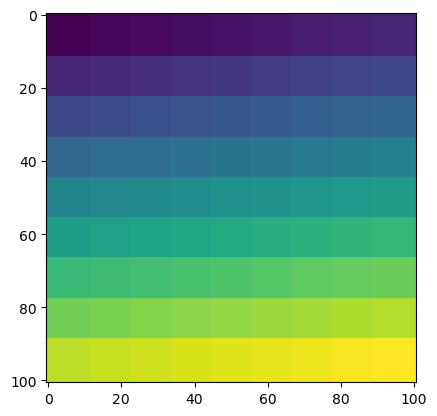

In [17]:
plt.imshow(grid_cells)

### Actions

In [18]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Observations

In [19]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [20]:
agent_state_labels = [label.split('-')[1] for label in state_labels[:np.prod(cells)]]

agent_state_labels[:5]

['a_0_0', 'a_0_1', 'a_0_2', 'a_0_3', 'a_0_4']

In [21]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

In [22]:
cell_probabilities = np.full(cells, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # TODO: Make it flexible to multi thresh
    cell_probabilities[*cell] = np.average(multiple_samples[:,*slices].astype(float))

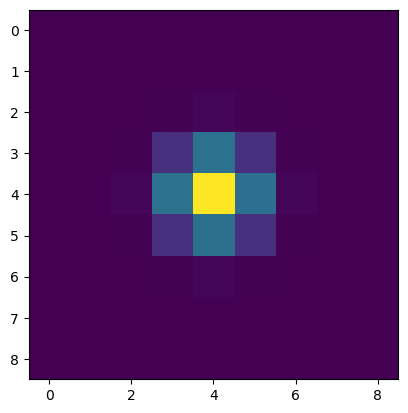

In [23]:
plt.imshow(cell_probabilities)

In [24]:
indices_array = np.array(indices_list)
relative_indices = indices_array[:,:len(cells)] - indices_array[:,len(cells):]

# Shifting the relative positions by the position of the center
center_pos = (cells / 2).astype(int)
centered_positions = relative_indices + center_pos

# Filtering to the valid centered positions
valid_positions = np.all((centered_positions >= 0) & (centered_positions < cells), axis=1)
filtered_centered_positions = centered_positions[valid_positions]
filtered_indices_array = indices_array[valid_positions]

# Gathering the cell_probabilities
odor_probabilities = np.zeros(combined_shape, dtype=float)
odor_probabilities[*filtered_indices_array.T] = cell_probabilities[*filtered_centered_positions.T]

In [25]:
# Generating an empty observation matrix
observations = np.zeros((cell_count+1, len(action_set), len(observation_labels)))

# Filling the "something" observations
agent_cells = indices_array[:np.prod(cells),2:]
for obs_i, agent_cell in enumerate(agent_cells):
    agent_cell_valid_indices = np.all(indices_array[:,2:] == agent_cell, axis=1)
    filtered_indices = indices_array[agent_cell_valid_indices]

    probabilities = odor_probabilities[*filtered_indices.T][:,None]

    observations[np.arange(cell_count)[agent_cell_valid_indices],:,obs_i] = 1 - probabilities
    observations[np.arange(cell_count)[agent_cell_valid_indices],:,obs_i+len(agent_cells)] = probabilities

# Goal observations
observations[-1,:,0] = 0.0
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

### Transitions

In [26]:
points = np.array(list(np.ndindex(tuple(space_shape))))

In [27]:
boundary_condition = 'stop'
movements_new_points = []

for movement in action_set:
    # Applying the movement vector
    new_pos = points + movement

    # Handling the case we are dealing with a single point.
    is_single_point = (len(pos.shape) == 1)
    if is_single_point:
        new_pos = new_pos[None,:]

    shape_array = np.array(space_shape)[None,:]

    # Wrap boundary
    if boundary_condition == 'wrap':
        new_pos = np.where(new_pos < 0, (new_pos + shape_array), new_pos)
        new_pos = np.where(new_pos >= shape_array, (new_pos - shape_array), new_pos)

    # Stop boundary
    elif boundary_condition == 'stop':
        new_pos = np.clip(new_pos, 0, (shape_array-1))

    movements_new_points.append(new_pos)

In [28]:
# cell_transition_probabilities = np.full((spacial_cell_count, len(action_set), spacial_cell_count), -1, dtype=float)

# for a, new_points in enumerate(movements_new_points):
#     for start_id in range(spacial_cell_count):
#         in_start_cell = (grid_cells[*np.array(points).T] == start_id)

#         for end_id in range(spacial_cell_count):
#             in_end_cell = (grid_cells[*np.array(new_points).T] == end_id)

#             cell_transition_probabilities[start_id,a,end_id] = np.sum((in_start_cell & in_end_cell)) / np.sum(in_start_cell)

In [29]:
# cell_transition_probabilities[12,3,:].reshape(cells)

In [30]:
transition_probabilities = np.full((cell_count+1, len(action_set), cell_count+1), -1, dtype=float)

spacial_cell_ids = cell_ids[0,0]
points_array = np.array(indices_list)

cell_centers = ((lower_bounds + upper_bounds) / 2).astype(int)
source_radius = 2

movements_new_points_array = np.array(movements_new_points)

for start_id, start_point in enumerate(indices_list):

    start_source_point = start_point[:2]
    start_source_id = spacial_cell_ids[*start_source_point]

    start_agent_point = start_point[2:]
    start_agent_id = spacial_cell_ids[*start_agent_point]


    # All other destination states have probability 0
    transition_probabilities[start_id,:,:-1] = 0.0

    # Filtering to the same source state set
    equal_end_states = np.all(points_array[:,:2] == start_source_point , axis=1)
    next_cell_ids = np.arange(cell_count)[equal_end_states]
    next_points_array = points_array[equal_end_states,2:]

    # Determine the position of the source in the source_cell
    source_position = cell_centers[start_source_id]

    # determine points in agent's starting cell
    in_start_cell = (grid_cells[*np.array(points).T] == start_agent_id)
    in_start_cell_count = np.sum(in_start_cell).astype(float)

    # determine next agent cell ids
    next_agent_id = spacial_cell_ids[*next_points_array.T]

    # determine points in agent's end cell
    in_end_cell = (grid_cells[*movements_new_points_array.T, None] == next_agent_id[None,None,:]) # |P| x |A| x |CELLS|

    # determine points that reached the source
    at_source = (((movements_new_points_array.T - source_position[:,None,None])**2).sum(axis=0) <= (source_radius**2))

    # Computing probabilities
    transition_probabilities[start_id,:,next_cell_ids] = np.sum(in_start_cell[:,None,None] & in_end_cell & (~at_source[:,:,None]), axis=0).astype(float).T / in_start_cell_count
    transition_probabilities[start_id,:,-1] = np.sum(in_start_cell[:,None] & at_source[:,:], axis=0).astype(float) / in_start_cell_count

transition_probabilities[-1,:,:] = 0.0
transition_probabilities[-1,:,-1] = 1.0

assert np.all(np.sum(transition_probabilities, axis=2).round(10) == 1.0), "Some transitions dont sum to 1"

# transition_probabilities /= np.sum(transition_probabilities, axis=2)[:,:,None]

In [31]:
# Simple test (sanity check)
source_center_state = (spacial_cell_count * int(spacial_cell_count / 2))
center_cell = source_center_state + int(spacial_cell_count / 2)
print(transition_probabilities[center_cell,0,source_center_state:source_center_state+spacial_cell_count].reshape(cells).round(3))
print(f'Goal prob: {transition_probabilities[center_cell,0,-1]:.3f}')

[[0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.091 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.802 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
Goal prob: 0.107


### Model

In [32]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [cell_count], # The very last state is the goal state
    # start_probabilities = start_probabilities,
    seed=12131415
)

## Training agent

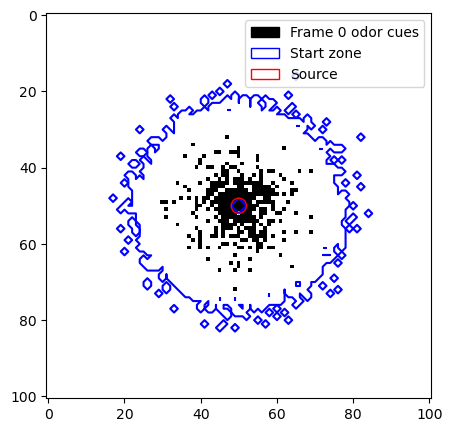

In [33]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='odor_present',
                              odor_present_threshold=3e-1)

artificial_env.plot()

### FSVI agent

In [34]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [35]:
_ = ag.train(expansions=300, use_gpu=True)

[09/10/2024, 18:10:46] MDP_policy, not provided. Solving MDP with Value Iteration...
[09/10/2024, 18:10:46] Sending Model to GPU...
[09/10/2024, 18:10:46]     > Done in 0.765s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 6562-state, 4-action
  - Converged in 918 iterations and 1.3862 seconds
  - Took on average 0.0015s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Memory full: Out of memory allocating 38,026,632,704 bytes (allocated so far: 46,118,217,728 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 6562 state, 4 action, 163 observations
  - Converged or stopped after 216 expansion steps and 215 backup steps.
  - Resulting value function has 1111 alpha vectors.
  - Converged in 248.1265s

  - Expand function took on average 0.0142s and yielded on average 739.83 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 1.1398s and yielded on average 5.16 alpha vectors per iteration. (0.0020s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


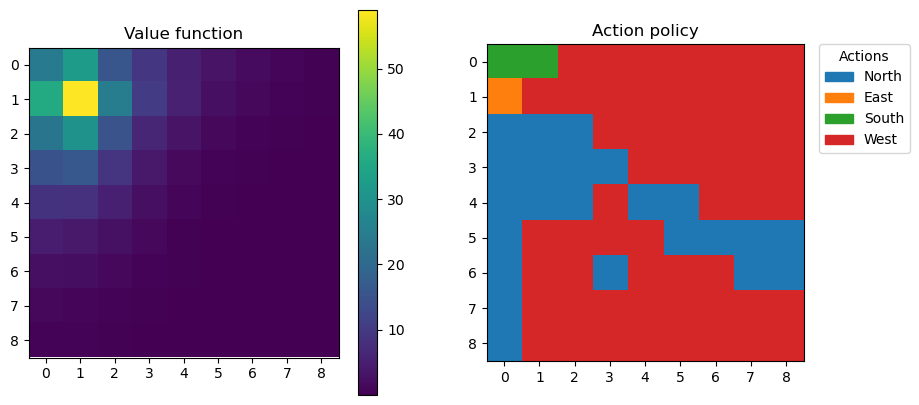

In [36]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [1,1]
source_policy_id = spacial_cell_ids[*source_policy]
source_state_start = source_policy_id * spacial_cell_count

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+spacial_cell_count]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+spacial_cell_count]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide 
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

## Testing agent

In [37]:
# data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

# source_position = (np.array([15,15]) / 0.8).astype(int)
# tank_size = (np.array([90,110]) / 0.8).astype(int)

# env = Environment(data_file=data,
#                   data_source_position=[66, 66],
#                   source_radius=2,
#                   layers=False,
#                   shape=[101,101],
#                   margins=0,
#                   boundary_condition='wrap_vertical',
#                   start_zone='odor_present',
#                   odor_present_threshold=3e-6)

# env.plot(frame=500)

In [38]:
# import h5py
# data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

# loaded_data = h5py.File(data_path,'r')
# data = np.array([loaded_data['odor_base'][timeslice] for timeslice in loaded_data['odor_base']])

# env = Environment(data_file=data,
#                   data_source_position=[66, 66],
#                   source_radius=2,
#                   layers=False,
#                   shape=[101,101],
#                   margins=0,
#                   boundary_condition='stop',
#                   start_zone='odor_present',
#                   odor_present_threshold=3e-10)

# env.plot(frame=500)

In [39]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [40]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

In [41]:
# From the starting points, gather what cell they came from
cell_indices_array = np.array(indices_list)
start_points_cell_ids = grid_cells[*start_points.T]
start_points_cells = cell_indices_array[:spacial_cell_count][start_points_cell_ids,2:]

In [42]:
beliefs = []

for cell in start_points_cells:
    all_source_states = np.argwhere(np.all(cell_indices_array[:,2:] == cell, axis=1))[:,0]

    # Defining start probabilities
    start_prob = np.zeros(cell_count+1, dtype=float)
    start_prob[all_source_states] = 1.0
    start_prob /= np.sum(start_prob)

    # Building belief point
    belief_point = Belief(model=model, values=start_prob)
    beliefs.append(belief_point)

all_beliefs = BeliefSet(model, beliefs)

In [43]:
# Initialization of the agent
ag.belief = all_beliefs

In [44]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                # skip_initialization=True,
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 14.458s:
Simulations reached goal: 126/2338 (2212 failures (reached horizon: 2212)) (5.39% success)
 - Average step count:                 952.235 +- 202.73 (Successfull only: 113.690 +- 140.01)
 - Extra steps:                        930.679 +- 201.50 (Successful only: 97.190 +- 134.13)
 - Average discounted rewards (ADR):   0.029 +- 0.15 (Successfull only: 0.541 +- 0.36)
 - Tmin/T:                             0.044 +- 0.12 (Successful only: 0.442 +- 0.35)


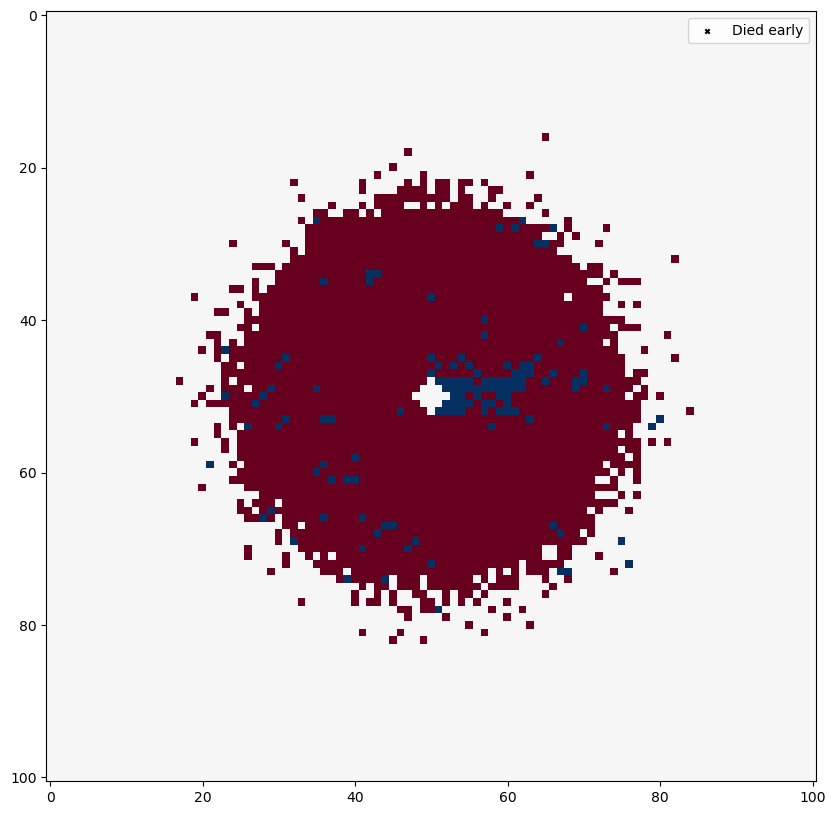

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

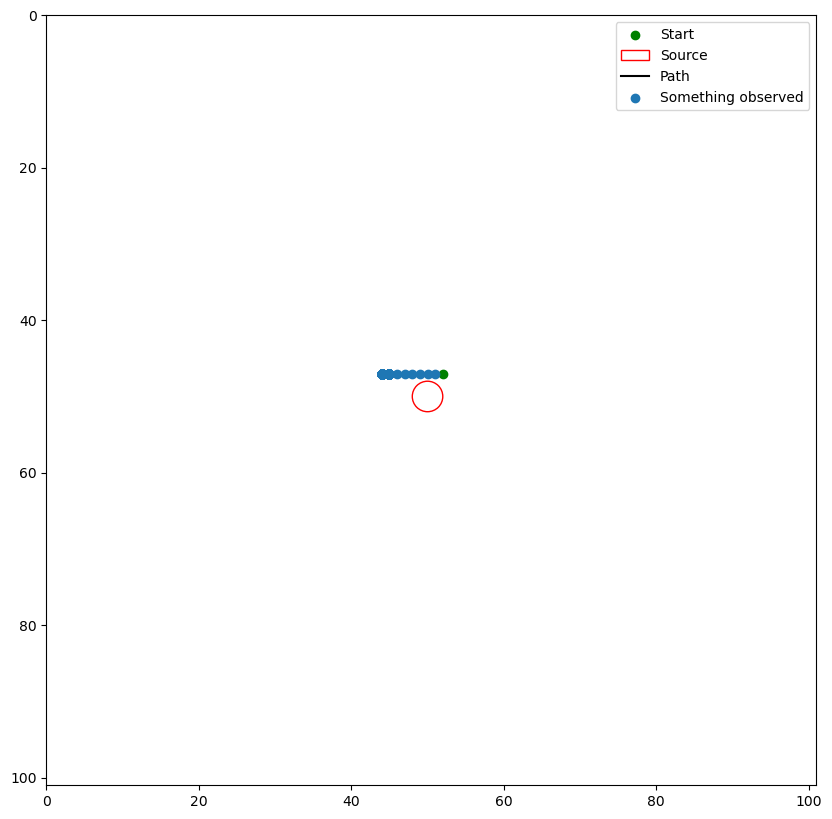

In [46]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(1000, ax= ax)